## importing packages

In [1]:
import os
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm  # Import tqdm


In [2]:
pip install tqdm


Note: you may need to restart the kernel to use updated packages.


## Lable Creation and Image Loading and Split training data

In [4]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file, header=None)
        self.root_dir = root_dir
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.labels_df[1] = self.label_encoder.fit_transform(self.labels_df[1])

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels_df.iloc[idx, 0])
        image = Image.open(img_name)
        label = torch.tensor(self.labels_df.iloc[idx, 1], dtype=torch.long)  # Convert label to tensor

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((60, 80)),
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create custom dataset
dataset = CustomDataset(csv_file='/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/data/labels.txt', root_dir='/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/data/images', transform=transform)

# Split dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load pre-trained ResNet50 model
model = torchvision.models.resnet50(pretrained=True)

# Modify the last layer for the number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.label_encoder.classes_))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jovyan/.cache/torch/checkpoints/resnet50-19c8e357.pth


## Training, Evaluating and Saving the model

In [5]:
# Train the model
model.train()
num_epochs = 1
for epoch in range(num_epochs):
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for inputs, labels in progress_bar:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({'Loss': running_loss / len(train_loader)})  # Update progress bar with current loss
    print(f"Epoch {epoch+1}, Loss: {running_loss}")

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total}%")

# Save the model
torch.save(model.state_dict(), '/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/models/torch.pth')


Epoch 1, Loss: 129.02946296078153
Accuracy on test set: 98.74001574980312%


## loading the model and defining Functions to predict for query image and extract colors

In [1]:
# Load the trained model for prediction
model = torchvision.models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.label_encoder.classes_))
model.load_state_dict(torch.load('/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/models/torch.pth'))
model.eval()

# Define transforms
transform = transforms.Compose([
    transforms.Resize((60, 80)),
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define function to predict category of a query image
def predict_category(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_label = dataset.label_encoder.inverse_transform([predicted.item()])  # Convert to list
    return predicted_label[0]

def extract_colors(image_path, num_colors=5):
    # Read the image
    image = cv2.imread(image_path)
    
    # Convert image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Flatten the image to a 2D array of pixels
    pixels = image.reshape(-1, 3)
    
    # Apply K-means clustering to find dominant colors
    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(pixels)
    
    # Get the dominant colors
    colors = kmeans.cluster_centers_
    
    return colors.astype(int)

def display_colors(colors):
    # Create a square image with the extracted colors
    color_img = np.zeros((100, len(colors)*100, 3), dtype=np.uint8)
    for i, color in enumerate(colors):
        color_img[:, i*100:(i+1)*100] = color
    
    # Display the image using matplotlib
    plt.imshow(color_img)
    plt.axis('off')
    plt.show()


NameError: name 'torchvision' is not defined

## more packages

In [8]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


## Predicting Class and Colors

Predicted category for query image: Footwear


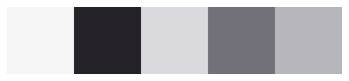

In [9]:
# Example usage
query_image_path = "/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/data/images2.jpeg"
predicted_category = predict_category(query_image_path)
print(f"Predicted category for query image: {predicted_category}")
colors = extract_colors(query_image_path)
display_colors(colors)

